In [189]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from paths import DATA_PATH
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch import nn

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [148]:
df = pd.read_csv(DATA_PATH / 'news_stocks.csv', parse_dates=True).reindex(index=df.index[::-1]).reset_index(drop=True)
df

,date,title,text,link,author,label,open,high,low,close,volume
0,2022-05-08,Заявки на транзит российского газа через Украи...,На уровне более 90 миллионов кубометров заявки...,https://www.finam.ru/publications/item/zayavki...,РИА Новости,positive,124.30,126.41,120.90,121.11,580965.0
1,2022-05-08,Юань - хороший инструмент для хеджирования рис...,Ввиду сильной экономики Китая юань менее подве...,https://www.finam.ru/publications/item/yuan-xo...,"Жильников Егор, ""Промсвязьбанк""",positive,124.30,126.41,120.90,121.11,580965.0
2,2022-05-08,"""Сбербанк"" увеличил сумму кредита по ипотеке с...",Сумма кредита по ипотеке с господдержкой увели...,https://www.finam.ru/publications/item/sberban...,Finam.ru,positive,124.30,126.41,120.90,121.11,580965.0
3,2022-05-08,Постпреды ЕС в воскресенье не достигли соглаше...,Венгрия продолжает блокировать предложение Евр...,https://www.finam.ru/publications/item/postpre...,РИА Новости,negative,124.30,126.41,120.90,121.11,580965.0
4,2022-05-08,Реальные доходы россиян в 2022 году могут упас...,По отношению к пиковому 2013 году реальные рас...,https://www.finam.ru/publications/item/realnye...,"Суворов Евгений, банк ""ЦентроКредит""",negative,124.30,126.41,120.90,121.11,580965.0
...,...,...,...,...,...,...,...,...,...,...,...
30609,2023-05-06,Результаты Ford по итогам прошедшего года можн...,Компания явно демонстрирует постепенное урегул...,https://www.finam.ru/publications/item/rezulta...,"Поздняков Дмитрий, Freedom Finance Global",positive,235.83,240.93,233.42,237.06,11352.0
30610,2023-05-06,"Банки США - депозиты сокращаются, кредиты растут",Ребалансировка балансов банков продолжается,https://www.finam.ru/publications/item/banki-s...,Сусин Егор,negative,235.83,240.93,233.42,237.06,11352.0
30611,2023-05-06,"Закрытие дивидендного реестра по ""Сбербанку"" с...",Последний день с рекордными дивидендами акции ...,https://www.finam.ru/publications/item/zakryti...,"Кожухова Елена, ИК ""Велес Капитал""",positive,235.83,240.93,233.42,237.06,11352.0
30612,2023-05-06,Встреча по зерновой сделке на уровне заместите...,"Встреча пройдет с участием России, Украины, Ту...",https://www.finam.ru/publications/item/vstrech...,Finam.ru,positive,235.83,240.93,233.42,237.06,11352.0


# using sentiment analysed news encode labels

In [282]:
one_hot = pd.get_dummies(df['label']).astype(int)

target_df = pd.concat([one_hot, df.volume, df.open, df.close], axis=1)
target_df

,negative,neutral,positive,volume,open,close
0,0,0,1,580965.0,124.30,121.11
1,0,0,1,580965.0,124.30,121.11
2,0,0,1,580965.0,124.30,121.11
3,1,0,0,580965.0,124.30,121.11
4,1,0,0,580965.0,124.30,121.11
...,...,...,...,...,...,...
30609,0,0,1,11352.0,235.83,237.06
30610,1,0,0,11352.0,235.83,237.06
30611,0,0,1,11352.0,235.83,237.06
30612,0,0,1,11352.0,235.83,237.06


# Split train and test

In [283]:
target='close'
features=['open', 'negative', 'neutral', 'positive', 'volume']
test_size = 0.22
n_samples = target_df.shape[0]


df_train = target_df[:n_samples - int(n_samples * test_size)]
df_test = target_df[-int(n_samples * test_size):]

target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

df_test

/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_75856/1811360299.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[c] = (df_train[c] - mean) / stdev
/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_75856/1811360299.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[c] = (df_test[c] - mean) / stdev


,negative,neutral,positive,volume,open,close
23879,1.534482,-0.373903,-1.018194,-0.630410,2.899547,2.856685
23880,-0.651658,-0.373903,0.982090,-0.630410,2.899547,2.856685
23881,-0.651658,-0.373903,0.982090,-0.630410,2.899547,2.856685
23882,1.534482,-0.373903,-1.018194,-0.630410,2.899547,2.856685
23883,-0.651658,-0.373903,0.982090,-0.630410,2.899547,2.856685
...,...,...,...,...,...,...
30609,-0.651658,-0.373903,0.982090,-1.566972,8.363709,8.317877
30610,1.534482,-0.373903,-1.018194,-1.566972,8.363709,8.317877
30611,-0.651658,-0.373903,0.982090,-1.566972,8.363709,8.317877
30612,-0.651658,-0.373903,0.982090,-1.566972,8.363709,8.317877


# Preparing a dataset for lstm-based regression model with lag

In [288]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [289]:
torch.manual_seed(101)

sequence_length=3

batch_size = 60

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([60, 3, 5])
Target shape: torch.Size([60])


In [290]:

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
#         batch_size = x.shape[0]
#         h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
#         c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
#         _, (hn, _) = self.lstm(x, (h0, c0))
#         out = self.linear(hn[0]).flatten()
#         return out    
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x
        

In [291]:
learning_rate = 1e-3
num_hidden_units = 16
epochs_count = 80 

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
# loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [292]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(epochs_count):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 36.34840596882643

Epoch 0
---------


/Users/ruslansirazhetdinov/Documents/MIPT/Учеба/nlpystocks/.venv.nosync/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ruslansirazhetdinov/Documents/MIPT/Учеба/nlpystocks/.venv.nosync/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ruslansirazhetdinov/Documents/MIPT/Учеба/nlpystocks/.venv.nosync/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([59])) that 

Train loss: 1.0000572628411815
Test loss: 35.72250571293114

Epoch 1
---------
Train loss: 1.0002121813033693
Test loss: 35.879319186759204

Epoch 2
---------
Train loss: 1.0000577772682036
Test loss: 36.222071550588694

Epoch 3
---------
Train loss: 1.000034214413945
Test loss: 36.22166892701546

Epoch 4
---------
Train loss: 0.9999171192172783
Test loss: 35.90421261407633

Epoch 5
---------
Train loss: 0.9999119698552031
Test loss: 35.92302053586572

Epoch 6
---------
Train loss: 0.9998835226399215
Test loss: 36.10224425898189

Epoch 7
---------
Train loss: 0.9996791378637055
Test loss: 35.617730773655715

Epoch 8
---------
Train loss: 0.9999870082840847
Test loss: 36.33127512974022

Epoch 9
---------
Train loss: 0.9999317073792069
Test loss: 35.87600600402967

Epoch 10
---------
Train loss: 0.9998475418018935
Test loss: 36.047856010166946

Epoch 11
---------
Train loss: 0.9998375235041183
Test loss: 36.199083492819184

Epoch 12
---------
Train loss: 1.0000020128548446
Test loss: 35.

In [275]:
predict(train_eval_loader, model).numpy()

array([[-0.03558358],
       [-0.03558358],
       [-0.03558358],
       ...,
       [-0.03558358],
       [-0.03558358],
       [-0.03558358]], dtype=float32)

In [293]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

predict_col = "forecast"

df_train[predict_col] = predict(train_eval_loader, model).numpy()
df_test[predict_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, predict_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

        close    forecast
0      121.11  126.399345
1      121.11  126.399345
2      121.11  126.399345
3      121.11  126.394318
4      121.11  126.390587
...       ...         ...
30609  237.06  126.822105
30610  237.06  126.807838
30611  237.06  126.820808
30612  237.06  126.822105
30613  237.06  126.807838

[30614 rows x 2 columns]


/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_75856/1579494236.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[predict_col] = predict(train_eval_loader, model).numpy()
/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_75856/1579494236.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[predict_col] = predict(test_loader, model).numpy()


Test MSE 35.95358470189837
Test MAPE 0.9904286259485019


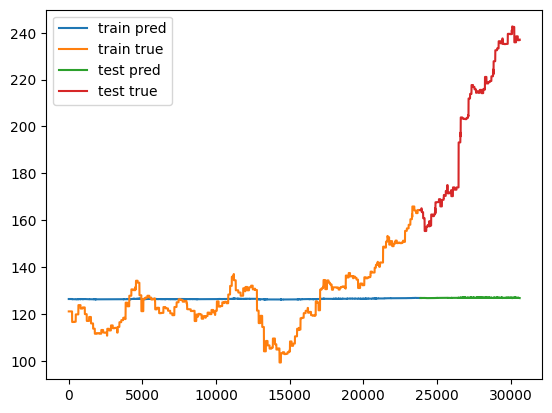

In [294]:
def running_mean(x, N,mode='valid'):
    return np.convolve(x, np.ones((N,))/N, mode=mode)

def test_model(moving_average=None):
    y_test = df_test['close']
    y_test_pred = df_test[predict_col]
    print('Test MSE', mean_squared_error(y_test, y_test_pred))
    print('Test MAPE', mean_absolute_percentage_error(y_test, y_test_pred))
    y_pred = df_out[predict_col]
    y = df_out['close']
    if moving_average:
        y_pred = running_mean(y_pred, moving_average)
        
        y_test_pred_smooth = running_mean(y_test_pred, moving_average, mode='same')
        print('Smoothed Test MSE', mean_squared_error(y_test, y_test_pred_smooth))
        print('Smoothed Test MAPE', mean_absolute_percentage_error(y_test, y_test_pred_smooth))
    fig, ax = plt.subplots(1,1)
    train_size = len(df_train)
    y_pred = pd.Series(y_pred)
    ax.plot(y_pred[:train_size], label='train pred')
    ax.plot(y[:train_size], label='train true')
    ax.plot(y_pred[train_size:], label='test pred')
    ax.plot(y[train_size:], label='test true')
    ax.legend()

test_model(moving_average=None)